This takes a crazy long amount of time, so I recommend doing an interactive job for this one with like 20 n_cpu

Number of Sources:	 65
Number of Events:	 1134450
Using nonparallel, time passed was: 	 8.404409
Number of Sources:	 65
Number of Events:	 1134450
Using nonparallel, time passed was: 	 7.705498
Number of Sources:	 65
Number of Events:	 1134450
Using nonparallel, time passed was: 	 7.540499
Number of Sources:	 65
Number of Events:	 1134450
Using nonparallel, time passed was: 	 7.501770
Number of Sources:	 65
Number of Events:	 1134450
Using nonparallel, time passed was: 	 7.611811
Number of Sources:	 65
Number of Events:	 1134450
Using nonparallel, time passed was: 	 7.901498
Number of Sources:	 65
Number of Events:	 1134450
Using nonparallel, time passed was: 	 7.641616
Number of Sources:	 65
Number of Events:	 1134450
Using nonparallel, time passed was: 	 7.742796
nonblazar agn, Nocut


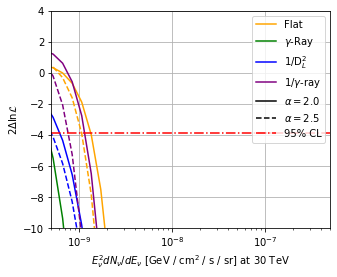

Number of Sources:	 47
Number of Events:	 1134450
Using nonparallel, time passed was: 	 5.399409
Number of Sources:	 47
Number of Events:	 1134450
Using nonparallel, time passed was: 	 5.457343
Number of Sources:	 47
Number of Events:	 1134450
Using nonparallel, time passed was: 	 5.424536
Number of Sources:	 47
Number of Events:	 1134450
Using nonparallel, time passed was: 	 5.468112
Number of Sources:	 47
Number of Events:	 1134450
Using nonparallel, time passed was: 	 5.437912
Number of Sources:	 47
Number of Events:	 1134450
Using nonparallel, time passed was: 	 5.590899
Number of Sources:	 47
Number of Events:	 1134450
Using nonparallel, time passed was: 	 5.695566
Number of Sources:	 47
Number of Events:	 1134450
Using nonparallel, time passed was: 	 5.731831
nonblazar agn, non_var


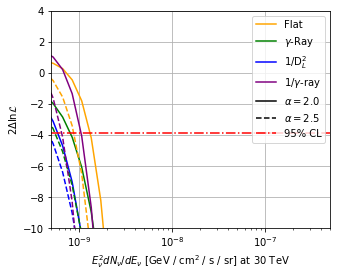

Number of Sources:	 2796
Number of Events:	 1134450
Using nonparallel, time passed was: 	 391.095727
Number of Sources:	 2796
Number of Events:	 1134450
Using nonparallel, time passed was: 	 350.117990
Number of Sources:	 2796
Number of Events:	 1134450
Using nonparallel, time passed was: 	 335.636340
Number of Sources:	 2796
Number of Events:	 1134450
Using nonparallel, time passed was: 	 338.757207
Number of Sources:	 2796
Number of Events:	 1134450
Using nonparallel, time passed was: 	 309.056775
Number of Sources:	 2796
Number of Events:	 1134450
Using nonparallel, time passed was: 	 287.091273
Number of Sources:	 2796
Number of Events:	 1134450
Using nonparallel, time passed was: 	 290.698032
Number of Sources:	 2796
Number of Events:	 1134450
Using nonparallel, time passed was: 	 293.652732
blazar agn, Nocut


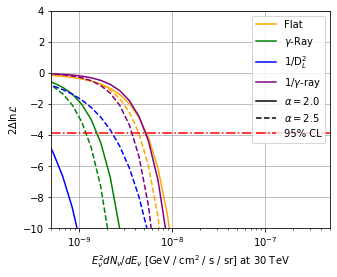

Number of Sources:	 1674
Number of Events:	 1134450
Using nonparallel, time passed was: 	 180.850580
Number of Sources:	 1674
Number of Events:	 1134450
Using nonparallel, time passed was: 	 180.848887
Number of Sources:	 1674
Number of Events:	 1134450
Using nonparallel, time passed was: 	 178.724057
Number of Sources:	 1674
Number of Events:	 1134450
Using nonparallel, time passed was: 	 180.827511
Number of Sources:	 1674
Number of Events:	 1134450
Using nonparallel, time passed was: 	 173.260039
Number of Sources:	 1674
Number of Events:	 1134450
Using nonparallel, time passed was: 	 174.057460
Number of Sources:	 1674
Number of Events:	 1134450
Using nonparallel, time passed was: 	 173.298785
Number of Sources:	 1674
Number of Events:	 1134450
Using nonparallel, time passed was: 	 173.315013
blazar agn, non_var


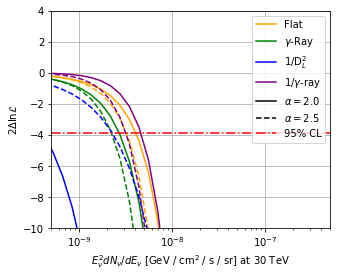

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import IceCubeAnalysis


def main(icecube_file_name, background_file_name, catalog_file_name, source_class_names,
         alpha=2.0, weights_type='flat', n_cpu=10, var_index_cut=None):
    """
    For points in the sky from the 4LAC catalog, the function scans
    over the number of neutrinos in the data from the source class
    and calculates the likelihood. The number of neutrinos associated
    to each source in the source class is determined by a weighting,
    which is described in more detail in the paper. If a statistically
    significant number of tracks in the data are associated with this
    source class, the resulting likelihood will peak above 3sigma.
    Parameters
    ----------
    icecube_file_name : str
        File location of pickled IceCube track data.
    background_file_name : str
        File location of pre-processed background PDF.
    catalog_file_name : str
        File location of pickled 4LAC catalog.
    source_class_names : array_like
        Names of source classes used in calculation.
    alpha : float
        Neutrino energy spectrum integrated with the effective area.
    weights_type : str
        The weighting used for the source class. Options are 'flat' for
        equal weight, 'flux' to weight against the gamma-ray flux, and
        'dist' to weight against the luminosity distance.
    n_cpu : int
        The number of CPUs to use in the parallelization.
        If n_cpu is None, the computation is not parallelized.
    var_index_cut : float
        Removes events that have a variability index greater
        than var_index_cut. If None, no cut is performed.
    Returns
    ----------
    sweep_flux : array
        The array of fluxes of astrophysical neutrinos used
        to calculate the likelihood of the source class
        producing said astrophysical neutrino flux.
    sweep_ts : array
        The cumulative likelihood of the source class producing
        the flux of astrophysical neutrinos.
    sweep_ts_each_source : array
        The likelihood of each individual source producing
        the flux of astrophysical neutrinos.
    """

    if(n_cpu is not None):
        use_parallel = True
    else:
        use_parallel = False
        
    sourcesearch_ = IceCubeAnalysis.SourceSearch(icecube_file_name)
    sourcesearch_.load_background(background_file_name)

    # The time used in integration, in seconds
    T = (10.0 * 365.25 * 24.0 * 3600.0)

    # The energy bounds used in integration.
    E1 = 100.0
    E2 = 30.0

    Aeff_filename = "./processed_data/output_icecube_AffIntegrated_%s.npz" % alpha
    class_search = IceCubeAnalysis.SourceClassSearch(T, E1, E2, alpha, sourcesearch_, Aeff_filename)

    
    class_search.load_4lac(catalog_file_name, source_class_names, weights_type)

    if(var_index_cut is not None):
        class_search.var_index_cut(var_index_cut)

    print("Number of Sources:\t %i" % class_search.N)
    print("Number of Events:\t %i" % sourcesearch_.N)

    start_time = time.time()

    if(use_parallel):
        args_for_multiprocessing = np.arange(class_search.N)

        pool = Pool(n_cpu)
        parallel_results = pool.map(class_search.source_loop,
                                    args_for_multiprocessing)
        pool.close()

        parallel_results = [list(t) for t in zip(*parallel_results)]

        sweep_ts_each_source = np.stack(parallel_results[1], axis=1)
        sweep_ts = np.sum(parallel_results[1], axis=0)
        sweep_flux = np.sum(parallel_results[0], axis=0)
    else:
        # Calculate the points that we will then loop over
        parameterized_span = class_search.calculate_span()

        sweep_ts = np.zeros(len(parameterized_span))
        sweep_flux = np.zeros(len(parameterized_span))
        sweep_ts_each_source = np.zeros((len(parameterized_span), class_search.N))

        for i_source in range(class_search.N):
            sweep_fluxes_, ts_results_ = class_search.source_loop(i_source)

            sweep_flux += sweep_fluxes_
            sweep_ts += ts_results_
            sweep_ts_each_source[:, i_source] = ts_results_

    end_time = time.time()

    if(use_parallel):
        print("Using parallel, time passed was: \t %f" % (end_time - start_time))
    else:
        print("Using nonparallel, time passed was: \t %f" % (end_time - start_time))

    sweep_flux *= 1000.0  # convert TeV to GeV

    return sweep_flux, sweep_ts, sweep_ts_each_source


if(__name__ == "__main__"):

    catalog_file_name = "./processed_data/4LAC_catelogy.npz"
    icecube_file_name = "./processed_data/output_icecube_data.npz"
    background_file_name = "./processed_data/output_icecube_background_count.npz"

    output_file_preamble = ['nonblazar','blazar']
    cut_type = ['Nocut','non_var']
    blazar = ['BLL', 'bll', 'FSRQ', 'fsrq', 'BCU', 'bcu']
    nonblazar = ['RDG', 'rdg', 'AGN', 'agn', 'NLSY1', 'nlsy1','CSS','css','SSRQ','ssrq','SEY','sey']
    source_class_names = [nonblazar, blazar]
    
    weights_types = ['flat', 'flux', 'dist','inv_flux']
    colors = ['orange', 'green', 'blue','purple']
    labels = ['Flat', r'$\gamma$-Ray', r'1/D$_L^2$',r'1/$\gamma$-ray']
    var_cut_types = [None, 18.48]

    alphas = [2.0, 2.5]
    linestyles = ['-', '--']

    for i_source_class_names, source_class_name in enumerate(source_class_names):
    
        for i_var_cut_types, var_cut_type in enumerate(var_cut_types):

            plt.figure(figsize=(5, 4))

            for i_alpha, alpha in enumerate(alphas):

                for i_weights_type, weights_type in enumerate(weights_types):
                    sweep_flux, sweep_ts, sweep_ts_each_source = main(icecube_file_name=icecube_file_name,
                                                                      background_file_name=background_file_name,
                                                                      catalog_file_name=catalog_file_name,
                                                                      source_class_names=source_class_name,
                                                                      alpha=alpha,
                                                                      weights_type=weights_type,
                                                                      n_cpu=10,
                                                                      var_index_cut=var_cut_type)

                    np.savez("./processed_data/limit_analysis_data/output_analysis_%s_%s_alpha%.1f_%s_limit.npz" % (output_file_preamble[i_source_class_names], cut_type[i_var_cut_types], alpha, weights_type),
                             flux_span=sweep_flux, results=sweep_ts)

                    plt.semilogx(np.array(sweep_flux)[sweep_ts < 1e3],
                                 sweep_ts[sweep_ts < 1e3],
                                 linestyle=linestyles[i_alpha],
                                 color=colors[i_weights_type])            

            for i_weights_type, weights_type in enumerate(weights_types):
                plt.plot([], [], color=colors[i_weights_type], label=labels[i_weights_type])

            for i_alpha, alpha in enumerate(alphas):
                plt.plot([], [], color='black', linestyle=linestyles[i_alpha], label=r"$\alpha=$" + str(alpha))

            plt.axhline(-3.85,
                        color="red",
                        linestyle="-.",
                        label="95% CL")

            plt.xlabel(r"$E^2_\nu dN_\nu/dE_\nu$ [GeV / cm$^2$ / s / sr] at 30 TeV")
            plt.ylabel("$2 \Delta \ln \mathcal{L}$")
            plt.xlim(5e-10, 5e-7)
            plt.ylim(-10.0, 4.0)
            plt.grid()
            plt.legend()

            #plt.savefig("./plots/A05_analyze_source_classes_limits_%s_%s_cut.png"%(output_file_preamble[i_source_class_names],cut_type[i_var_cut_types]), dpi=300)
            print('%s agn, %s' % (output_file_preamble[i_source_class_names],cut_type[i_var_cut_types]))
            plt.show()